<h3>Проект e-learning</h3>

**Файлы**: 

- **assessments.csv** — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
    - code_module — идентификационный код предмета.
    - code_presentation — семестр (Идентификационный код).
    - id_assessment — тест (Идентификационный номер ассессмента).
    - assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
    - date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
    - weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.
- **courses.csv** — файл содержит список предметов по семестрам.
    - code_module — предмет (идентификационный код).
    - code_presentation — семестр (идентификационный код).
    - module_presentation_length — продолжительность семестра в днях.
- **studentAssessment.csv** — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
    - id_assessment — тест (идентификационный номер).
    - id_student — идентификационный номер студента.
    - date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
    - is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
    - score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.
- **studentRegistration.csv** — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.
    - code_module — предмет (идентификационный код).
    - code_presentation — семестр (идентификационный код)
    - id_student — идентификационный номер студента.
    - date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
    - date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)



In [1]:
import pandas as pd
import seaborn as sns

In [2]:
assessments = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-petrova-25/midterm_project/assessments.csv')
courses = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-petrova-25/midterm_project/courses.csv')
studentAssessment = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-petrova-25/midterm_project/studentAssessment.csv')
studentRegistration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-petrova-25/midterm_project/studentRegistration.csv')

In [3]:
df_exam = studentAssessment.merge(assessments, how = 'inner').query('assessment_type == "Exam"')

In [4]:
df_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


In [5]:
df_exam.query('score >= 40')  \
        .groupby('id_student', as_index = False).agg({'id_assessment': 'nunique'}) \
        .rename(columns = {'id_assessment': 'modules_passed'}).query('modules_passed == 1') \
        .shape[0]

3802

In [6]:
df_exam.id_student.nunique()

4633

**Ответ**: из 4633 сдававших какие-либо экзамены 3802 студентов успешно сдали только один экзамен.

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью (завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен)

In [7]:
module_completion = (df_exam.query('score >= 40 and is_banked == 0').groupby(['code_module', 'id_assessment']).score.count() / \
                    df_exam.groupby(['code_module', 'id_assessment']).score.count()).round(2) \
                    .reset_index().rename(columns = {'score': 'completion'})

In [8]:
module_completion

,code_module,id_assessment,completion
0,CCC,24290,0.89
1,CCC,24299,0.87
2,DDD,25340,0.84
3,DDD,25354,0.91
4,DDD,25361,0.93
5,DDD,25368,0.89


In [9]:
module_completion.groupby('code_module').agg({'completion': 'mean'}).round(2)

,completion
code_module,
CCC,0.88
DDD,0.89


**Ответ**: самая низкая завершаемость у экзамена с кодом 25340, самая высокая - у экзамена 25361, они оба относятся к предмету DDD. В среднем же (если брать данные по всем экзаменам) у предметов CCC и DDD близкие показатели завершаемости.<br>
При этом необходимо учитывать, что у нас есть данные только по двум предметам и шести экзаменам, тогда как для остальных предметов и экзаменов данных по сдаче нет.

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

In [10]:
df_exam.query('score  >= 40') \
        .groupby(['code_module', 'id_student'], as_index = False).agg({'date_submitted': 'max'}) \
        .groupby('code_module').agg({'date_submitted': 'mean'}).round()

,date_submitted
code_module,
CCC,239.0
DDD,238.0


**Ответ**: для предмета CCC средний срок сдачи экзаменов составляет 239 дней, для DDD - 238 дней.

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

In [11]:
registered = studentRegistration.groupby('code_module', as_index = False).agg({'id_student': 'nunique'}) \
                                .rename(columns = {'id_student': 'registrations'})

In [12]:
unregistered = studentRegistration.fillna(0).query('date_unregistration != 0') \
                                    .groupby('code_module', as_index = False).agg({'id_student': 'nunique'}) \
                                    .rename(columns = {'id_student': 'unregistrations'})

In [13]:
reg_unreg = registered.merge(unregistered)

reg_unreg['сhurn'] = (reg_unreg.unregistrations / reg_unreg.registrations).round(2)

In [14]:
reg_unreg.sort_values('registrations', ascending = False)[:3]

,code_module,registrations,unregistrations,сhurn
1,BBB,7692,2184,0.28
5,FFF,7397,2133,0.29
3,DDD,5848,1988,0.34


In [15]:
reg_unreg.sort_values('сhurn', ascending = False)[:3]

,code_module,registrations,unregistrations,сhurn
2,CCC,4251,1823,0.43
3,DDD,5848,1988,0.34
5,FFF,7397,2133,0.29


**Ответ**:
- топ-3 предметов по количеству регистраций: BBB, FFF, DDD;
- топ-3 предмета по оттоку (определённому как процент отменивших регистрацию от общего числа зарегистрированных): CCC, DDD,	FFF.

5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [16]:
def cohort(df):
    module_max_date = df.query('score >= 40').groupby(['code_presentation']).agg({'date_submitted': 'mean'}) \
                      .rename(columns = {'date_submitted': 'mean_date'}).round().sort_values('mean_date', ascending = False)[:1]
    module_least_completion = (df.query('score >= 40').groupby(['code_presentation']).agg({'score': 'count'}) / \
                               df.groupby(['code_presentation']).agg({'score': 'count'})) \
                               .rename(columns = {'score': 'completion'}).round(2).sort_values('completion')[:1]
    return module_max_date, module_least_completion

In [17]:
module_max_date, module_least_completion = cohort(df_exam)

In [18]:
module_least_completion

,completion
code_presentation,
2013B,0.84


In [19]:
module_max_date

,mean_date
code_presentation,
2014J,244.0


**Ответ**: самая низкая завершаемость была в семестре 2013B, самые долгие средние сроки сдачи экзаменов - в семестре 2014J.<br>
Данные охватывают только период 2013-2014 года, поэтому дополнительной фильтрации по дате не требуется.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: *R* - среднее время сдачи одного экзамена, *F* - завершаемость курсов, *M* - среднее количество баллов, получаемое за экзамен.<br>
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.


Для начала создадим датафрейм с необходимыми метриками.

Среднее время (успешной) сдачи одного экзамена для каждого студента:

In [20]:
mean_pass = df_exam.query('score >= 40').groupby('id_student', as_index = False).agg({'date_submitted': 'mean'}) \
                    .rename(columns = {'date_submitted': 'mean_pass'})
mean_pass.head()

,id_student,mean_pass
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0


In [21]:
mean_pass.shape[0]

4097

Завершаемость курсов для каждого студента (как и выше, кол-во успешных экзаменов / кол-во всех попыток сдать экзамены). Для тех, кто не завершил ни одного курса, она будет равняться нулю:

In [22]:
completion = (df_exam.query('score >= 40').groupby('id_student').score.count() / \
                df_exam.groupby('id_student').score.count()) \
                .reset_index().fillna(0).rename(columns = {'score': 'completion'})
completion.head()

,id_student,completion
0,23698,1.0
1,24213,1.0
2,27116,1.0
3,28046,1.0
4,28787,1.0


In [23]:
completion.shape[0]

4633

Средний балл за экзамен для каждого студента:

In [24]:
mean_score = df_exam.groupby('id_student', as_index = False).agg({'score': 'mean'}).rename(columns = {'score': 'mean_score'})
mean_score.head()

,id_student,mean_score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0


In [25]:
mean_score.shape[0]

4633

Соединяем все метрики и id студентов в один датафрейм:

In [26]:
df_rfm = mean_pass.merge(completion, on = 'id_student', how = 'right').merge(mean_score, on = 'id_student', how = 'inner')
df_rfm.head()

,id_student,mean_pass,completion,mean_score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


In [27]:
df_rfm.shape[0]

4633

Смотрим распределения наших метрик:

In [28]:
df_rfm.describe()

,id_student,mean_pass,completion,mean_score
count,4.633000e+03,4097.000000,4633.000000,4633.000000
mean,7.256904e+05,238.466317,0.881286,65.117958
std,5.753498e+05,5.632457,0.321142,20.470561
min,2.369800e+04,229.000000,0.000000,0.000000
25%,5.011580e+05,234.000000,1.000000,50.000000
50%,5.884820e+05,241.000000,1.000000,66.000000
75%,6.463510e+05,243.000000,1.000000,82.000000
max,2.698251e+06,285.000000,1.000000,100.000000


Среднее время сдачи экзамена:

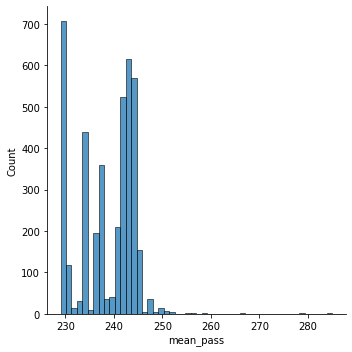

In [29]:
sns.displot(df_rfm.mean_pass)

По результатам метода desribe и графику распределения среднего времени можно увидеть, что 25% студентов сдают экзамены за первую неделю (229-235 день), ещё 25% студентов - за вторую неделю (235-241 день), а оставшиеся 50% - после 241 дня, причём большинство - за третью неделю. Возможно, это связано с механикой сдачи экзамена либо с выходными днями (поскольку видны чёткие пики на конкретных днях). Представляется разумным сделать разбивку по неделям.<br>
Также необходимо добавить категорию для тех, кто не сдал успешно ни одного экзамена (для них условно среднее время сдачи равно нулю).<br>
Таким образом границами категорий будут 0, 229, 235 и 241.

Завершаемость:

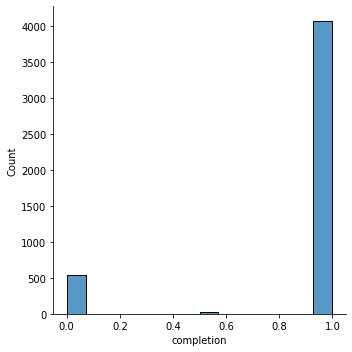

In [30]:
sns.displot(df_rfm.completion)

На графике распределения завершаемости видно три пика. Посмотрим на них подробнее:

In [31]:
df_rfm.query('completion > 0.4 and completion < 0.6').completion.value_counts()

0.5    28
Name: completion, dtype: int64

In [32]:
df_rfm.query('completion < 0.1').completion.value_counts()

0.0    536
Name: completion, dtype: int64

In [33]:
df_rfm.query('completion > 0.9').completion.value_counts()

1.0    4069
Name: completion, dtype: int64

In [34]:
#все ли данные укладываются в эти три значения? Всего у нас 4633 студента 
4069 + 536 + 28

4633

Как видно, завершаемость в наших данных имеет три дискретных значения: 0, 0.5 и 1. Разумно использовать их как три категории.

Средняя оценка за экзамен:

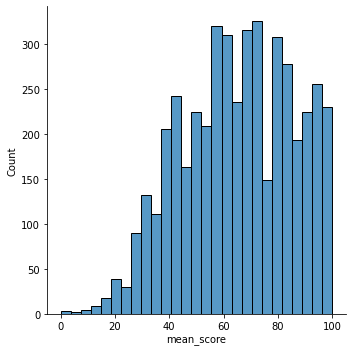

In [35]:
sns.displot(df_rfm.mean_score)

Из метода describe и графика видно, что средняя оценка имеет приближенное к нормальному распределение с квартилями 50, 66 и 82. Представляется разумным оставить четыре категории для этой метрики, но в первую выделить тех студентов, которые так и не сдали экзамен (средняя оценка меньше 40), а остальные категории привязать к квартилям распределения. Тогда границы категорий будут 40, 66 и 82.

Пишем функции для кластеризации наших данных:

In [36]:
#для удобства вычисления примем среднее время сдачи экзамена для тех, кто не сдал ни одного, равным нулю
df_rfm.mean_pass = df_rfm.mean_pass.fillna(0)

In [37]:
#для среднего времени сдачи (4 категории, первая - не сдавшие ни одного экзамена):
def r_score(r):
    if r == 0:
        return 1
    if r > 0 and r <= 235:
        return 2
    if r > 235 and r <= 241:
        return 3
    if r > 241:
        return 4

In [38]:
#для завершаемости (3 категории с дискретными значениями):
def f_score(f):
    if f == 0:
        return 1
    if f == 0.5:
        return 2
    if f == 1:
        return 3

In [39]:
#для среднего балла (4 категории, первая - не сдавшие ни одного экзамена, остальные - по квартилям распределения метрики)
def m_score(m):
    if m < 40:
        return 1
    if m >= 40 and m < 66:
        return 2
    if m >= 66 and m < 82:
        return 3
    if m >= 82:
        return 4

In [40]:
df_rfm['R'] = df_rfm.mean_pass.apply(r_score)
df_rfm['F'] = df_rfm.completion.apply(f_score)
df_rfm['M'] = df_rfm.mean_score.apply(m_score)

Итого мы получаем датафрейм с разбивкой студентов на кластеры:

In [41]:
df_rfm.head()

,id_student,mean_pass,completion,mean_score,R,F,M
0,23698,243.0,1.0,80.0,4,3,3
1,24213,236.0,1.0,58.0,3,3,2
2,27116,243.0,1.0,96.0,4,3,4
3,28046,237.0,1.0,40.0,3,3,2
4,28787,243.0,1.0,44.0,4,3,2


Пример интерпретации кластера: студенты в сегменте 432 имеют метрику recency более 241 дня, frequency равную 0.5, monetary от 40 до 66 баллов.

При этом из-за природы данных и принятого разбиения при равенстве любой из метрик 1 остальные также будут равны 1.